In [1]:
import Pkg
Pkg.add("Turing")
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("Plots")
Pkg.add("ReverseDiff")
Pkg.add("Memoization")


    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [0656b61e] ↑ GLFW_jll v3.3.5+0 ⇒ v3.3.5+1
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   R

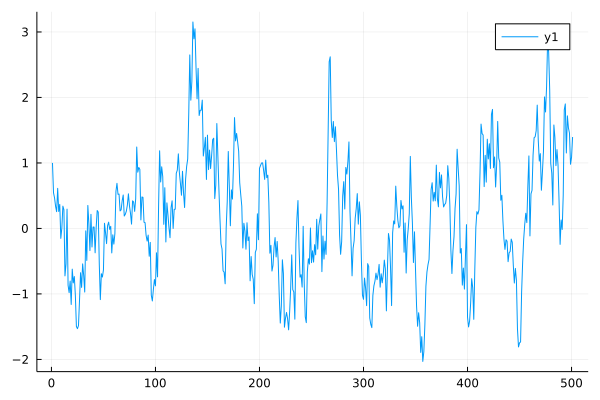

In [2]:
using DifferentialEquations
using Plots

μ = 0.0
σ = sqrt(2)
Θ = 1.0
W = OrnsteinUhlenbeckProcess(Θ,μ,σ,0.0,1.0)
prob = NoiseProblem(W,(0.0,50.0))
sol = solve(prob;dt=0.1)
plot(sol.u)

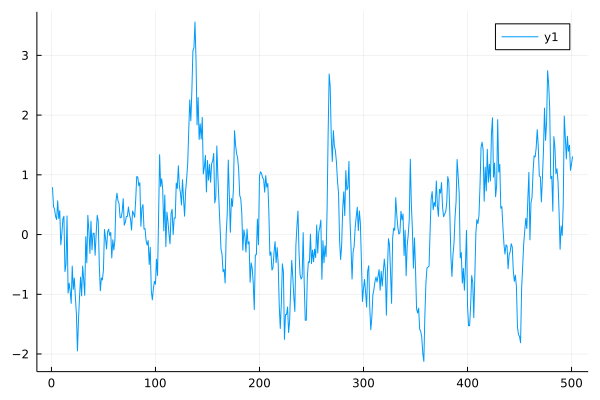

In [3]:
using Distributions, Random
ou_data = sol.u
noise = rand.(Normal.(0,0.1*abs.(ou_data)))
plot(ou_data.+noise)
# plot(noise)


In [4]:
using Turing, ReverseDiff, Memoization
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)
using Distributions
using LinearAlgebra

# Ornstein-Uhlenbeck process
@model ou(rn,T,delta_t) = begin
    ampl ~ Uniform(0.0,5.0)
    tau ~ Uniform(0.0,5.0)
    
    b = exp(-delta_t/tau)
    
    rn[1] ~ Normal(0,sqrt(ampl))
    
    for i=2:T
        rn[i] ~ Normal(rn[i-1]*b,sqrt(ampl*(1-b^2)))
    end
end

# Ornstein-Uhlenbeck process with added Gaussian noise
@model oupn(rn,T,delta_t,::Type{R}=Vector{Float64}) where {R} = begin
    ampl ~ Uniform(0.0,5.0)
    tau ~ Uniform(0.0,5.0)
    noise_ampl ~ Uniform(0.0,1)
    
    b = exp(-delta_t/tau)
    r = R(undef, T)
    
    r[1] ~ Normal(0,sqrt(ampl))
    
    for i=2:T
        r[i] ~ Normal(r[i-1]*b,sqrt(ampl*(1-b^2)))
    end
    rn ~ MvNormal(r,abs.(r).*noise_ampl)
end

oupn (generic function with 3 methods)

In [13]:
using StatsPlots
@time chnou = sample(ou(ou_data,length(ou_data),0.1), NUTS(0.65), 2000)
# Summarise results (currently requires the master branch from MCMCChains)
describe(chnou)


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/noahdean/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:23


 82.537622 seconds (113.04 M allocations: 7.815 GiB, 3.04% gc time, 0.19% compilation time)


2-element Vector{ChainDataFrame}:
 Summary Statistics (2 x 8)
 Quantiles (2 x 6)

In [ ]:
using StatsPlots
data = ou_data .+ noise
@time chnpn = sample(oupn(data,length(data),0.1), NUTS(0.65), 2000)
describe(chnpn)

2000×1002 Matrix{Float64}:
 1.1011   -0.86774   1.20345  0.57404   …  1.55651  0.582328  -0.630402
 1.10112  -0.867253  1.20356  0.574898     1.55624  0.582738  -0.630728
 1.10115  -0.869822  1.20322  0.575443     1.55682  0.582804  -0.630954
 1.10117  -0.869613  1.2017   0.57415      1.55752  0.582012  -0.631533
 1.1013   -0.876399  1.2032   0.572015     1.55684  0.580918  -0.631323
 1.10127  -0.875814  1.20314  0.570497  …  1.55663  0.581508  -0.630739
 1.10106  -0.87406   1.20326  0.569279     1.55696  0.581883  -0.630321
 1.10149  -0.876883  1.20256  0.569701     1.55747  0.582004  -0.630507
 1.10139  -0.87548   1.20228  0.569241     1.55765  0.581846  -0.630303
 1.10139  -0.877208  1.20254  0.571117     1.55871  0.580367  -0.629601
 1.10113  -0.875761  1.20324  0.57344   …  1.55839  0.581617  -0.629598
 1.10132  -0.87705   1.20382  0.576288     1.5574   0.578659  -0.628723
 1.10133  -0.877307  1.2034   0.577224     1.55644  0.57949   -0.628977
 ⋮                                   

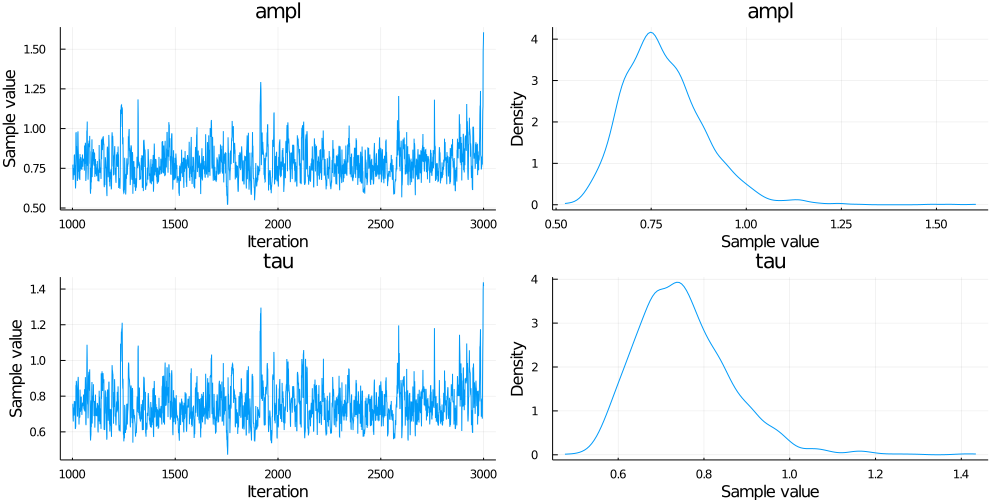

In [19]:
# Plot and save results
using Plots
p = plot(chnou)

In [32]:
# ampl_data = chnpn[:ampl].value.data
# print(mean(ampl_data[:,1,1]))
# plot(ampl_data[:,1,1])
chnpn

Chains MCMC chain (2000×1017×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 14378.02 seconds
Compute duration  = 14378.02 seconds
parameters        = r[440], r[117], r[444], r[315], r[375], r[495], r[821], r[734], r[79], r[165], r[197], r[271], r[206], r[903], r[14], r[356], r[85], r[538], r[805], r[807], r[926], r[565], r[512], r[769], r[920], r[875], r[622], r[786], r[407], r[673], r[693], r[799], r[621], r[576], r[746], r[971], r[587], r[509], r[639], r[638], r[460], r[362], r[122], r[318], r[890], r[811], r[973], r[320], r[434], r[547], r[278], r[840], r[70], r[820], r[932], r[641], r[282], r[257], r[566], r[836], r[996], r[106], r[620], r[80], r[605], r[636], r[424], r[148], r[10], r[336], r[291], r[873], r[957], r[27], r[827], r[976], r[667], r[532], r[606], r[837], r[251], r[361], r[454], r[343], r[163], r[200], r[703], r[934], r[981], r[795], r[700], r[613], r[670], r[367], r[396], r[632], r[545], r[135]

1.286234347189734

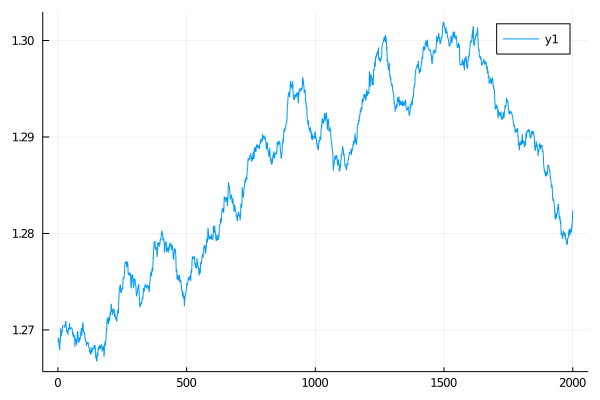

In [33]:
print(mean(chnpn[:ampl][:,1,1]))

plot(chnpn[:ampl][:,1,1])

In [71]:
r_data = chnpn.value.data[:, 4:1005]
r_mean= mean(r_data,dims=1)[1,:,1]



1002-element Vector{Float64}:
  1.1056870415938043
 -0.9006887825302752
  1.1914546108465278
  0.6169331539053626
 -0.8806659362553246
 -1.168203927280048
 -0.7424601224731568
 -1.8084274810403334
 -1.084043954530479
 -0.5094592397824951
 -1.014544440157922
  0.14021287374174143
  1.9844155399481107
  ⋮
  0.8344556928510121
 -0.03682369905342729
 -1.199117539761422
  1.609534575118929
 -1.7152101262886728
  0.03674021202259291
  0.28656035061986357
 -0.039054515196950204
  1.606880579315889
  1.5639875907847987
  0.6033228592004009
 -0.6259499687628963

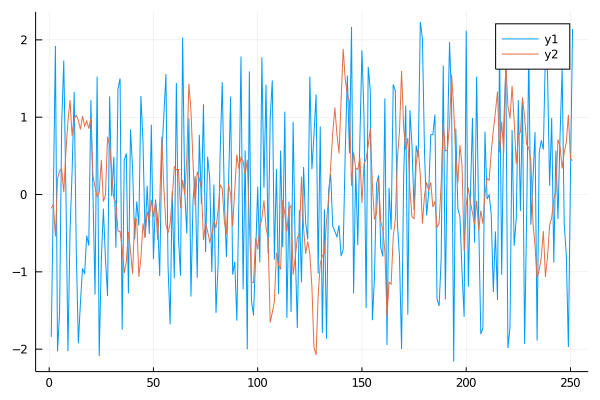

In [75]:
plot(r_mean[250:500])
plot!(sol.u[250:500])

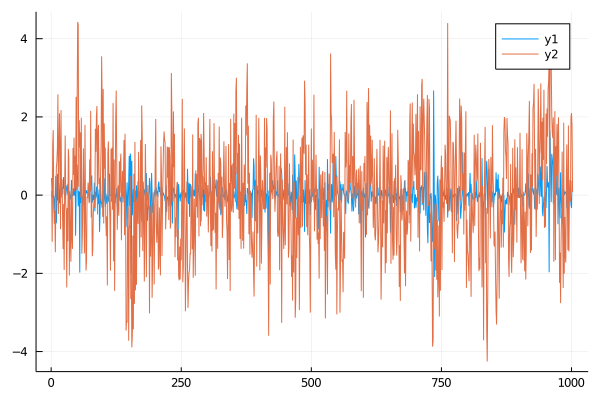

In [74]:
plot(noise)
plot!(r_mean.-sol.u)